# 1- Data Acquisition

We are going to use a dataset that is already collected.

In [1]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [12]:
import pandas as pd
import json
from glob import glob
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt



In [3]:
def jsonl_to_dataframe(file_path):
    """Fonction pour lire un fichier JSONL et retourner un DataFrame pandas"""
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            data.append(json.loads(line))
    return pd.DataFrame(data)

def merge_jsonl_to_dataframe(file_pattern):
    """Fonction pour fusionner plusieurs fichiers JSONL en un seul DataFrame pandas"""
    # Récupérer la liste des fichiers correspondant au modèle fourni
    files = glob(file_pattern)
    
    
    # Lire chaque fichier JSONL et stocker les DataFrames individuels dans une liste
    dfs = [jsonl_to_dataframe(file) for file in files]
    # Concaténer les DataFrames
    merged_df = pd.concat(dfs, ignore_index=True)
    
    return merged_df

# Modèle de chemin vers les fichiers JSONL à fusionner
file_pattern = "data/*.jsonl"

# Appel de la fonction pour fusionner les fichiers JSONL en un DataFrame
df = merge_jsonl_to_dataframe(file_pattern)

# Afficher le DataFrame fusionné
len(df)

48644

#  Setup the dataFrame for the predictive models

In [4]:
# Creating the answers_df
human_df = pd.DataFrame({'answers': df['human_answers'], 'is_human': 1})
gpt_df = pd.DataFrame({'answers': df['chatgpt_answers'], 'is_human': 0})
answers_df = pd.concat([human_df, gpt_df], axis=0, ignore_index=True)

# Checking the len
answers_df['len'] = answers_df['answers'].apply(len)
answers_df = answers_df.explode('answers', ignore_index=True)
answers_df = answers_df.dropna(subset=['answers'])

answers_df

,answers,is_human,len
0,"Basically there are many categories of "" Best ...",1,3
1,"If you 're hearing about it , it 's because it...",1,3
2,"One reason is lots of catagories . However , h...",1,3
3,salt is good for not dying in car crashes and ...,1,3
4,"In Minnesota and North Dakota , they tend to u...",1,3
...,...,...,...
171803,It is generally a good idea for stay-at-home m...,0,1
171804,A SEP (Simplified Employee Pension) is a type ...,0,1
171805,"When you make a purchase with a credit card, t...",0,1
171806,If you're interested in beginning your investm...,0,2


In [5]:
answers_df.head()

,answers,is_human,len
0,"Basically there are many categories of "" Best ...",1,3
1,"If you 're hearing about it , it 's because it...",1,3
2,"One reason is lots of catagories . However , h...",1,3
3,salt is good for not dying in car crashes and ...,1,3
4,"In Minnesota and North Dakota , they tend to u...",1,3


# 2. Exploring the data

Whenever we start working with a new dataset, and before we move on to making design decisions and creating a model, we have to get to know our data. Let’s answer some questions regarding our dataset:

**What does human_answers or chatgpt_answers looks like?**

In [6]:
#Human

human_answers_df = answers_df[answers_df['is_human'] == 1]
first_human_answer = human_answers_df.iloc[0]['answers']
print(first_human_answer)


Basically there are many categories of " Best Seller " . Replace " Best Seller " by something like " Oscars " and every " best seller " book is basically an " oscar - winning " book . May not have won the " Best film " , but even if you won the best director or best script , you 're still an " oscar - winning " film . Same thing for best sellers . Also , IIRC the rankings change every week or something like that . Some you might not be best seller one week , but you may be the next week . I guess even if you do n't stay there for long , you still achieved the status . Hence , # 1 best seller .


In [7]:
#Chatgpt

chatgpt_answers_df = answers_df[answers_df['is_human'] == 0]
first_chatgpt_answer = chatgpt_answers_df.iloc[0]['answers']
print(first_chatgpt_answer)

There are many different best seller lists that are published by various organizations, and the New York Times is just one of them. The New York Times best seller list is a weekly list that ranks the best-selling books in the United States based on sales data from a number of different retailers. The list is published in the New York Times newspaper and is widely considered to be one of the most influential best seller lists in the book industry. 
It's important to note that the New York Times best seller list is not the only best seller list out there, and there are many other lists that rank the top-selling books in different categories or in different countries. So it's possible that a book could be a best seller on one list but not on another. 
Additionally, the term "best seller" is often used more broadly to refer to any book that is selling well, regardless of whether it is on a specific best seller list or not. So it's possible that you may hear about a book being a "best selle

**How long are the responses? from humans? from chatgpt?**

Mean responses length:  680.6854097632631
Min overview length:  5
Max overview length:  36793


/tmp/ipykernel_57859/4104485100.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_answers_df['responses_length'] = human_answers_df.answers.apply(len)


<Axes: ylabel='Frequency'>

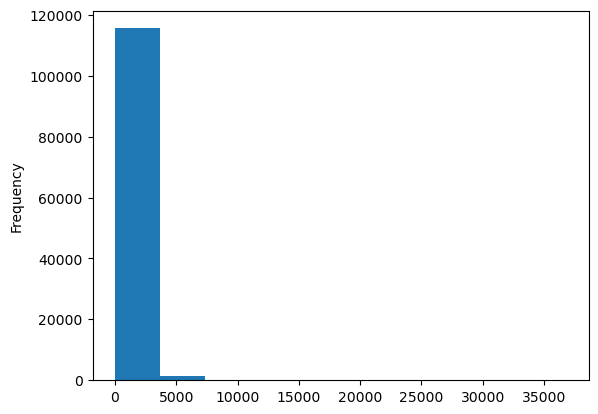

In [8]:
#Human 

human_answers_df['responses_length'] = human_answers_df.answers.apply(len)
print("Mean responses length: ", human_answers_df['responses_length'].mean())
print("Min overview length: ", human_answers_df['responses_length'].min())
print("Max overview length: ", human_answers_df['responses_length'].max())
human_answers_df.responses_length.plot.hist()

Mean responses length:  1010.5089395234733
Min overview length:  0
Max overview length:  3508


/tmp/ipykernel_57859/2606865523.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chatgpt_answers_df['responses_length'] = chatgpt_answers_df.answers.apply(len)


<Axes: ylabel='Frequency'>

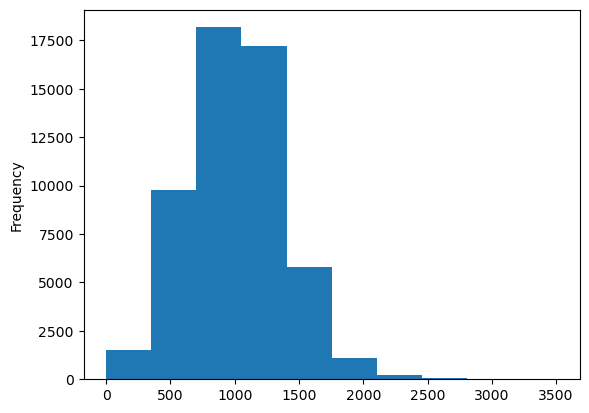

In [9]:
#Chatgpt

chatgpt_answers_df['responses_length'] = chatgpt_answers_df.answers.apply(len)
print("Mean responses length: ", chatgpt_answers_df['responses_length'].mean())
print("Min overview length: ", chatgpt_answers_df['responses_length'].min())
print("Max overview length: ", chatgpt_answers_df['responses_length'].max())
chatgpt_answers_df.responses_length.plot.hist()

**A word cloud to see what are the most common words in the responses**

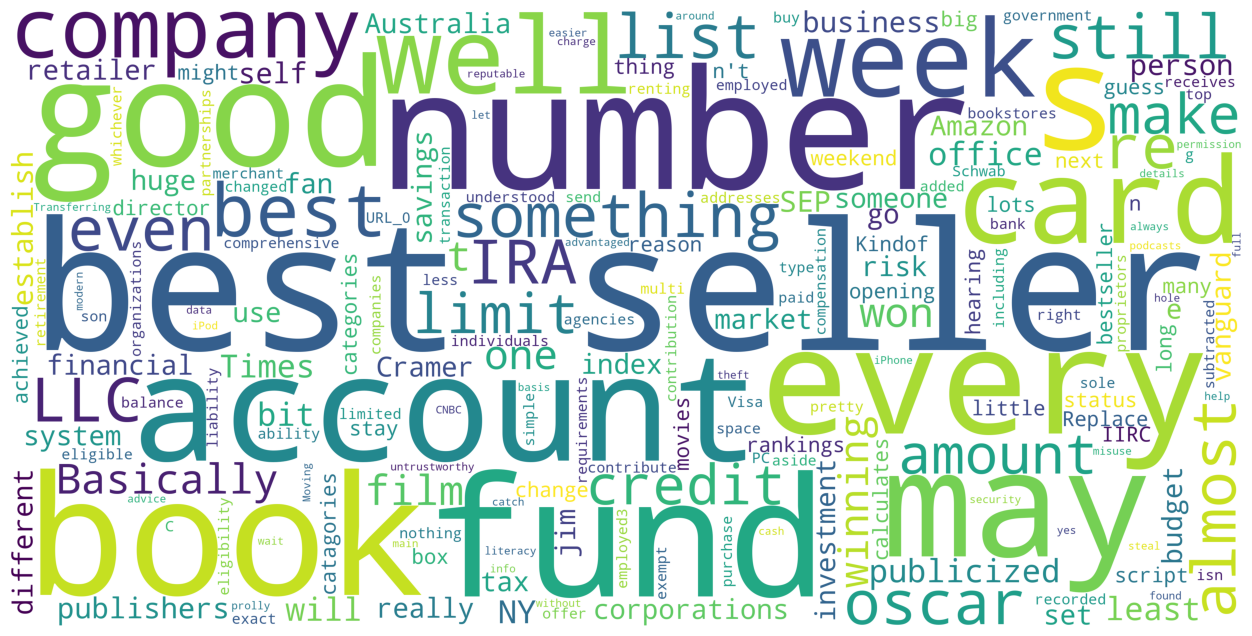

In [13]:
#Human

stopwords = set(STOPWORDS)
humans_words_text = human_answers_df['answers'].values
wordcloud = WordCloud(stopwords=stopwords, background_color='white', height=2000, width=4000).generate(str(humans_words_text))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


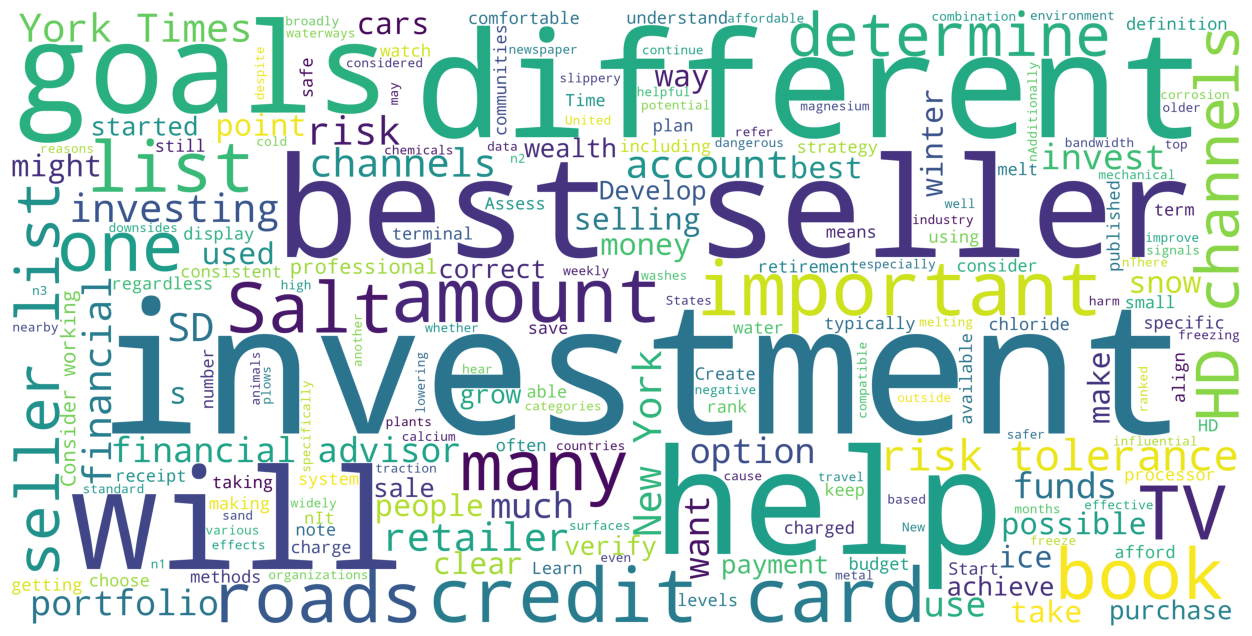

In [14]:
#Chatgpt

stopwords = set(STOPWORDS)
chatgpt_words_text = chatgpt_answers_df['answers'].values
wordcloud = WordCloud(stopwords=stopwords, background_color='white', height=2000, width=4000).generate(str(chatgpt_words_text))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
X = answers_df['answers']
y = answers_df['is_human']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 